In [23]:
import pandas as pd
import re
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

df = pd.read_csv('FE_data.csv')

In [26]:
# Print all column headers
column_headers = df.columns.tolist()
print(column_headers)

# Dropping the original column headers
columns_to_drop = ['Accelerometer_acceleration_x_(m/s^2)', 'Accelerometer_acceleration_y_(m/s^2)',
                   'Accelerometer_acceleration_z_(m/s^2)', 'Gyroscope_gyroscope_x_(rad/s)',
                   'Gyroscope_gyroscope_y_(rad/s)', 'Gyroscope_gyroscope_z_(rad/s)']

df = df.drop(columns=columns_to_drop)


['name', 'trial', 'posture', "('Accelerometer_acceleration_x_(m/s^2)', 'max')", "('Accelerometer_acceleration_x_(m/s^2)', 'min')", "('Accelerometer_acceleration_x_(m/s^2)', 'mean')", "('Accelerometer_acceleration_x_(m/s^2)', 'std')", "('Accelerometer_acceleration_x_(m/s^2)', 'median')", "('Accelerometer_acceleration_y_(m/s^2)', 'max')", "('Accelerometer_acceleration_y_(m/s^2)', 'min')", "('Accelerometer_acceleration_y_(m/s^2)', 'mean')", "('Accelerometer_acceleration_y_(m/s^2)', 'std')", "('Accelerometer_acceleration_y_(m/s^2)', 'median')", "('Accelerometer_acceleration_z_(m/s^2)', 'max')", "('Accelerometer_acceleration_z_(m/s^2)', 'min')", "('Accelerometer_acceleration_z_(m/s^2)', 'mean')", "('Accelerometer_acceleration_z_(m/s^2)', 'std')", "('Accelerometer_acceleration_z_(m/s^2)', 'median')", "('Gyroscope_gyroscope_x_(rad/s)', 'max')", "('Gyroscope_gyroscope_x_(rad/s)', 'min')", "('Gyroscope_gyroscope_x_(rad/s)', 'mean')", "('Gyroscope_gyroscope_x_(rad/s)', 'std')", "('Gyroscope_gyro

In [27]:
def transform_feature_names(df):
    transformed_columns = []
    for column in df.columns:
        # Remove special characters using regular expressions
        transformed_column = re.sub('[^A-Za-z0-9_]+', '_', column)
        transformed_columns.append(transformed_column)
    
    return transformed_columns

# Assuming 'df' is your DataFrame
transformed_columns = transform_feature_names(df)
df.columns = transformed_columns

# Use the transformed column names in your code
df = df[transformed_columns]

# replace the values separated by '_' to the right values
df['posture'] = df['posture'].replace('bed_fall', 'bedfall')
df['posture'] = df['posture'].replace('chair_fall', 'chairfall')

#df.head(20)


#### This part is used when one wants to perform binary classification

In [31]:
# If we want to model only a binary classification between fall and no_fall
df['posture'] = df['posture'].replace(['laying', 'sitting'], 'no_fall')
df['posture'] = df['posture'].replace(['bed_fall', 'bedfall', 'chair_fall', 'chairfall', 'stairfall', 'stumbling'], 'fall')
df

,name,trial,posture,_Accelerometer_acceleration_x__m_s_2_max_,_Accelerometer_acceleration_x__m_s_2_min_,_Accelerometer_acceleration_x__m_s_2_mean_,_Accelerometer_acceleration_x__m_s_2_std_,_Accelerometer_acceleration_x__m_s_2_median_,_Accelerometer_acceleration_y__m_s_2_max_,_Accelerometer_acceleration_y__m_s_2_min_,...,_Gyroscope_gyroscope_y__rad_s_max_,_Gyroscope_gyroscope_y__rad_s_min_,_Gyroscope_gyroscope_y__rad_s_mean_,_Gyroscope_gyroscope_y__rad_s_std_,_Gyroscope_gyroscope_y__rad_s_median_,_Gyroscope_gyroscope_z__rad_s_max_,_Gyroscope_gyroscope_z__rad_s_min_,_Gyroscope_gyroscope_z__rad_s_mean_,_Gyroscope_gyroscope_z__rad_s_std_,_Gyroscope_gyroscope_z__rad_s_median_
0,Anshu,1,fall,0.698440,0.433133,0.544834,0.014219,0.545840,0.619940,0.270059,...,0.713280,0.249395,0.415397,0.021758,0.416345,0.547391,0.116257,0.388581,0.016048,0.388952
1,Anshu,1,fall,0.600995,0.398032,0.484320,0.017943,0.483416,0.838683,0.334601,...,0.529024,0.312310,0.417506,0.024865,0.417069,0.558365,0.308126,0.387820,0.015270,0.389257
2,Anshu,1,no_fall,0.602147,0.445350,0.509183,0.022598,0.503747,0.630410,0.374496,...,0.546897,0.301151,0.420433,0.028623,0.419378,0.478921,0.297765,0.387994,0.014817,0.389304
3,Anshu,1,no_fall,0.606788,0.490623,0.535439,0.013577,0.535882,0.588683,0.389534,...,0.519163,0.241588,0.413418,0.029865,0.413545,0.435101,0.322133,0.388212,0.011954,0.389257
4,Anshu,1,fall,1.000000,0.389949,0.531052,0.017302,0.530117,0.567505,0.140425,...,0.575567,0.225843,0.414115,0.027362,0.414249,0.680419,0.162688,0.389647,0.017258,0.389222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,Raul,5,fall,0.795041,0.428507,0.500603,0.016490,0.502364,0.709016,0.418976,...,0.554331,0.329762,0.416454,0.018696,0.416059,0.500937,0.317412,0.390849,0.014513,0.389554
86,Raul,5,no_fall,0.568599,0.437789,0.499308,0.013088,0.500935,0.594128,0.361241,...,0.490826,0.344774,0.416926,0.016685,0.416198,0.453956,0.336268,0.389772,0.009721,0.389200
87,Raul,5,no_fall,0.553123,0.428768,0.495693,0.008988,0.495341,0.560132,0.365713,...,0.494652,0.330245,0.417671,0.019784,0.416275,0.430661,0.354304,0.388768,0.007577,0.389144
88,Raul,5,fall,0.630069,0.238148,0.505528,0.021304,0.507358,0.678990,0.254423,...,0.534006,0.270693,0.417782,0.022911,0.416325,0.462032,0.267988,0.389753,0.013664,0.389405


Best Parameters:
learning_rate: 0.1
max_depth: 1
n_estimators: 100
num_leaves: 5
Accuracy: 0.3333333333333333
Recall: [0.33333333 0.         0.         0.5        0.5        0.5       ]


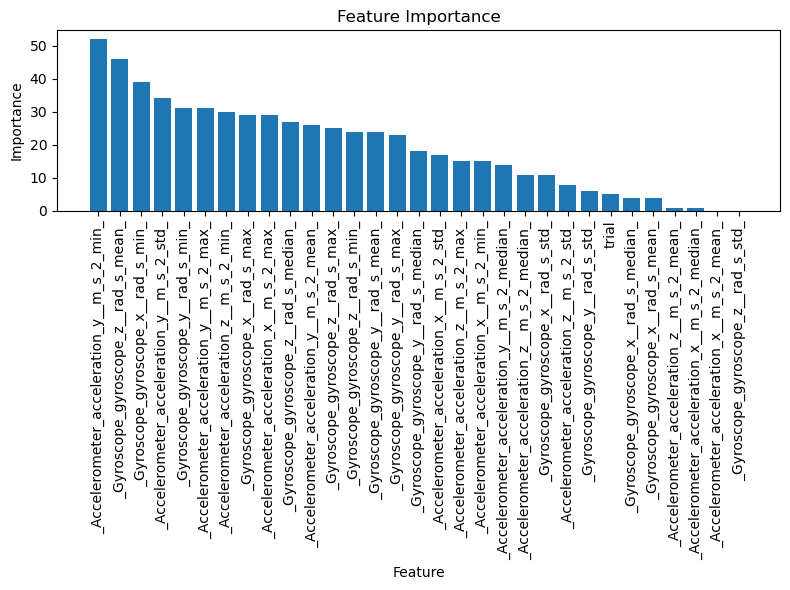

In [29]:
# Split the data into features (X) and target variable (y)
X = df.drop(['posture', 'name'], axis=1)  # Features
y = df['posture']  # Target variable

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM classifier
model = lgb.LGBMClassifier()

# Define the parameter grid for hyperparameter search
param_grid = {
    'num_leaves': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 2, 5, 10],
    'n_estimators': [20, 50, 100, 150]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
best_model = lgb.LGBMClassifier(**best_params)

# Train the model with the best hyperparameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# --------------- EVAL ------------------------
# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate recall scores for each class
recall_scores = recall_score(y_test, y_pred, average=None)
print(f"Recall: {recall_scores}")

# Get feature importance
feature_importance = best_model.feature_importances_
df_feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
df_feature_importance = df_feature_importance.sort_values(by='Importance', ascending=False)

# Create the bar plot
plt.figure(figsize=(8, 6))
plt.bar(df_feature_importance['Feature'], df_feature_importance['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()

# Show the plot
plt.show()

# print("Feature Importance:")
# print(df_feature_importance)

### Some other plots including: precision recall curve, confusion matrix, classification report, ROC Curve

Best Parameters:
learning_rate: 0.05
max_depth: 1
n_estimators: 20
num_leaves: 5
Accuracy: 0.8333333333333334
Recall: [1.  0.5]


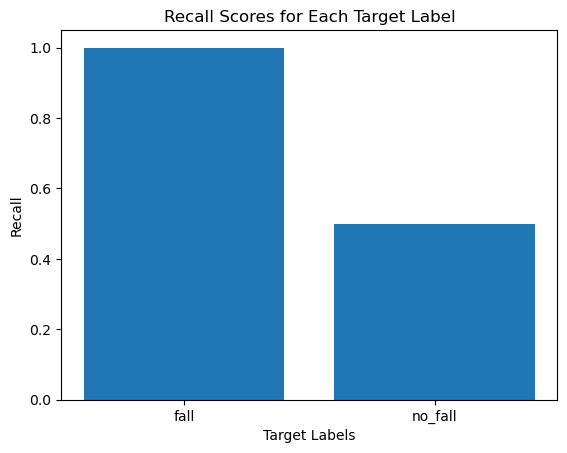

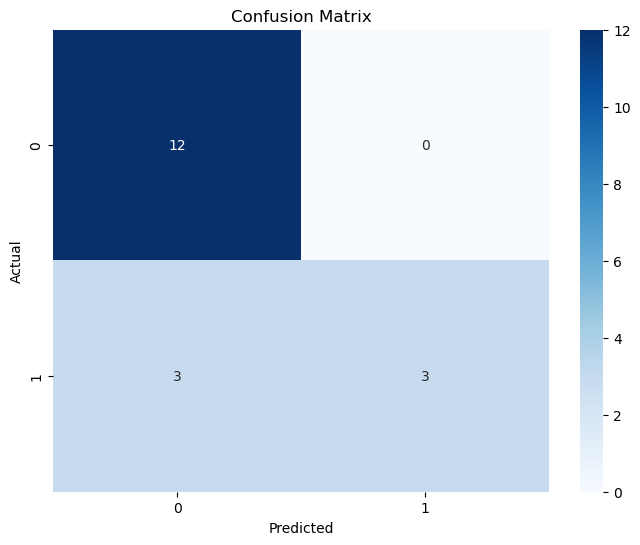

Classification Report:
              precision    recall  f1-score   support

        fall       0.80      1.00      0.89        12
     no_fall       1.00      0.50      0.67         6

    accuracy                           0.83        18
   macro avg       0.90      0.75      0.78        18
weighted avg       0.87      0.83      0.81        18



Text(0.5, 1.0, 'Precision-Recall Curve')

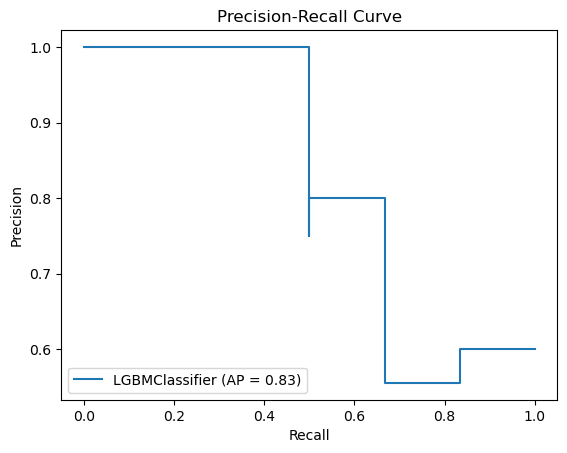

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

# Split the data into features (X) and target variable (y)
X = df.drop(['posture', 'name'], axis=1)  # Features
y = df['posture']  # Target variable

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM classifier
model = lgb.LGBMClassifier()

# Define the parameter grid for hyperparameter search
param_grid = {
    'num_leaves': [5, 10, 20],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [1, 2, 5, 10],
    'n_estimators': [20, 50, 100, 150]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=3)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
best_model = lgb.LGBMClassifier(**best_params)

# Train the model with the best hyperparameters
best_model.fit(X_train, y_train)

# Predict on the test set
y_pred = best_model.predict(X_test)

# --------------- EVAL ------------------------
# Get the best hyperparameters
best_params = grid_search.best_params_

print("Best Parameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Calculate recall scores for each class
recall_scores = recall_score(y_test, y_pred, average=None)
print(f"Recall: {recall_scores}")

# Create a bar plot for recall scores
labels = label_encoder.inverse_transform(range(len(recall_scores)))
plt.bar(labels, recall_scores)
plt.xlabel('Target Labels')
plt.ylabel('Recall')
plt.title('Recall Scores for Each Target Label')
plt.show()

# Calculate and plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print Classification Report
class_names = label_encoder.classes_
classification_rep = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:")
print(classification_rep)

#-------------BINARY CLASSIFICATION------------------------------

# Plot Precision-Recall Curve
disp = plot_precision_recall_curve(best_model, X_test, y_test)
disp.ax_.set_title('Precision-Recall Curve')

# Calculate and plot ROC Curve
# fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
# plt.show()
